In [1]:
import clickhouse_driver
from keyrings.cryptfile.cryptfile import CryptFileKeyring
kr = CryptFileKeyring()
cfg = {'host': kr.get_password("etl", "dwh_host"), 'port': kr.get_password("etl", "dwh_port"), 'database': kr.get_password("etl", "dwh_database"),
       'user': kr.get_password("etl", "dwh_user"), 'password': kr.get_password("etl", "dwh_password")}

Please enter password for encrypted keyring:  ······


In [2]:
import pandas as pd
import numpy as np
import math
import clickhouse_driver
# from pymongo import MongoClient
from tqdm import tqdm
import datetime

In [3]:
smart_q = pd.read_csv('smart_lab_quartal.csv')

/tmp/ipykernel_28194/3510607918.py:1: DtypeWarning: Columns (53,54,55,59,60,61,62,63,64,65,66) have mixed types. Specify dtype option on import or set low_memory=False.
  smart_q = pd.read_csv('smart_lab_quartal.csv')


In [4]:
smart_q.drop(columns='Unnamed: 0.1', inplace=True)

In [5]:
smart_q.rename(columns={'Unnamed: 0':'metric'}, inplace=True)

In [6]:
pd.options.display.float_format ='{:,.3f}'.format
pd.options.display.max_rows = 400

In [7]:
metric_get = smart_q.groupby('metric')['Company'].nunique().reset_index().sort_values('Company', ascending=False).reset_index()[:30].metric.to_list()

In [8]:
df=smart_q[smart_q['metric'].isin(metric_get)]

In [ ]:
df.set_index(['metric', 'Company'])

In [ ]:
smart_q[smart_q['metric'].isin(metric_get)].shape

In [ ]:
smart_q[smart_q['metric'].isin(metric_get)].isnull().sum().reset_index().sort_values(0)

In [ ]:
f=['2016Q4', '2017Q1', '2017Q4', '2018Q1', '2018Q2', '2018Q3',
       '2018Q4', '2019Q1', '2019Q2', '2019Q3', '2019Q4', '2020Q1', '2020Q2',
       '2020Q3', '2020Q4', '2021Q1', '2021Q2', '2021Q3', '2021Q4', '2022Q2',
       '2022Q4', '2023Q2', '2023Q4',  '2017Q2', '2017Q3',
       '2022Q1', '2022Q3', '2023Q1', '2023Q3', '2024Q1', '2016Q2', '2009Q4',
       '2010Q4', '2011Q4', '2012Q4', '2013Q4', '2014Q4', '2015Q4', '2016Q3',
       '2006Q4', '2007Q4', '2008Q4', '2015Q1', '2015Q2', '2015Q3', '2016Q1',
       '2014Q1', '2014Q2', '2014Q3', '2012Q1', '2012Q2', '2012Q3', '2013Q1',
       '2013Q2', '2013Q3', '2011Q1', '2011Q2', '2011Q3', '2000Q4', '2001Q4',
       '2002Q4', '2003Q4', '2004Q4', '2005Q4']

In [ ]:
df.pivot(index=f, columns='metric', values='Company')

In [ ]:
df[(df['Company']=='ENPG' )& (df['metric']=='Выручка, млрд руб')].T.reset_index()

In [10]:
res=pd.DataFrame()
for comp in df.Company.unique():
    df_=df[df['Company']==comp ]
    df_.set_index('metric',inplace=True)
    df_ = df_.T
    df_['Company']=comp
    res = pd.concat([res, df_])

In [12]:
res=res.reset_index()

In [13]:
res['year'] = res['index'].apply(lambda x: x[:4])

In [14]:
res['quartal'] = res['index'].apply(lambda x: x[-2:])

In [ ]:
res.to_csv('smart_transform.csv')

In [15]:
res=res[~res['index'].isin(['LTM','Company'])]

In [16]:
res=res[res['Дата отчета'].notnull()]

In [19]:
res[['Дата отчета','date']]

metric,Дата отчета,date
0,26.06.2018,2018-06-26
1,18.05.2018,2018-05-18
2,26.06.2018,2018-06-26
3,18.05.2018,2018-05-18
4,15.08.2018,2018-08-15
...,...,...
17048,11.05.2023,2023-05-11
17049,18.09.2023,2023-09-18
17065,04.07.2018,2018-07-04
17066,04.07.2018,2018-07-04


In [ ]:
res.dtypes

In [ ]:
res.columns

In [21]:
for col in ['Выручка, млрд руб',
       'Чистая прибыль, млрд руб', 'CAPEX, млрд руб', 'Див доход, ао, %',
       'Дивиденды/прибыль, %', 'Активы, млрд руб', 'Чистые активы, млрд руб',
       'Долг, млрд руб', 'Наличность, млрд руб', 'Чистый долг, млрд руб',
       'Цена акции ао, руб', 'Число акций ао, млн', 'Капитализация, млрд руб',
       'EV, млрд руб', 'Баланс стоимость, млрд руб', 'EPS, руб',
       'FCF/акцию, руб', 'BV/акцию, руб', 'Рентаб EBITDA, %',
       'Чистая рентаб, %', 'Доходность FCF, %', 'ROE, %', 'ROA, %', 'P/E',
       'P/S', 'P/BV', 'R&D/CAPEX, %', 'CAPEX/Выручка, %']:
    res[col] = res[col].apply(lambda x: str(x).replace(' ', '').replace('%', ''))
    res[col] = res[col].astype(float)

In [20]:
# res['date'] = pd.to_datetime(res['Дата отчета'], format="%d.%m.%Y")
res['Дата отчета'] = pd.to_datetime(res['Дата отчета'], format="%d.%m.%Y")

In [29]:
res['Дата отчета'].max()

Timestamp('2024-05-24 00:00:00')

In [33]:
res.sort_values(['Дата отчета'], ascending=False)

metric,index,Дата отчета,Валюта отчета,"Выручка, млрд руб","Чистая прибыль, млрд руб","CAPEX, млрд руб","Див доход, ао, %","Дивиденды/прибыль, %","Активы, млрд руб","Чистые активы, млрд руб",...,"ROA, %",P/E,P/S,P/BV,"R&D/CAPEX, %","CAPEX/Выручка, %",Company,year,quartal,date
15541,2024Q1,2024-05-24,RUB,3.150,0.740,NaN,0.000,0.000,11.300,8.000,...,19.600,27.200,4.900,10.800,NaN,0.000,CIAN,2024,Q1,2024-05-24
4783,2024Q1,2024-05-24,RUB,NaN,4.400,NaN,0.000,0.000,274.100,48.900,...,1.600,26.000,NaN,2.340,NaN,NaN,LEAS,2024,Q1,2024-05-24
11581,2024Q1,2024-05-23,RUB,35.200,2.470,4.370,0.000,0.000,151.100,62.900,...,4.400,3.730,0.190,0.400,0.000,12.000,MRKC,2024,Q1,2024-05-23
14749,2024Q1,2024-05-22,RUB,NaN,22.200,NaN,0.000,0.000,NaN,NaN,...,NaN,7.250,NaN,NaN,NaN,NaN,TCSG,2024,Q1,2024-05-22
3850,2023Q4,2024-05-17,RUB,NaN,NaN,NaN,NaN,NaN,92.600,22.100,...,0.000,NaN,NaN,0.000,NaN,NaN,ELMT,2023,Q4,2024-05-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15426,2014Q1,2014-04-17,RUB,29.400,NaN,3.810,NaN,NaN,137.400,58.400,...,0.000,NaN,0.000,0.000,0.000,13.000,PHOR,2014,Q1,2014-04-17
11981,2011Q4,2012-07-18,RUB,NaN,NaN,NaN,0.000,NaN,812.000,498.000,...,0.000,NaN,NaN,0.560,NaN,NaN,HYDR,2011,Q4,2012-07-18
11989,2008Q4,2012-07-18,RUB,NaN,NaN,NaN,NaN,NaN,426.000,342.000,...,0.000,NaN,NaN,0.000,NaN,NaN,HYDR,2008,Q4,2012-07-18
11979,2009Q4,2012-07-18,RUB,NaN,NaN,NaN,0.000,NaN,483.000,401.000,...,0.000,NaN,NaN,0.000,NaN,NaN,HYDR,2009,Q4,2012-07-18


In [ ]:
res[['index','Дата отчета']].sort_values('Дата отчета', ascending=False)

In [22]:
print(datetime.datetime.now())

pvo = pd.read_sql("""select * from PercentageVolumeOscillatorRU """, con=clickhouse_driver.connect(**cfg))

print(datetime.datetime.now())
print('done')

2024-06-10 18:13:01.901418


/home/psm/.pyenv/versions/3.9.13/envs/jupyterhub/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


2024-06-10 18:13:02.865898
done


In [23]:
pvo['date'] = pd.to_datetime(pvo['date'])

In [24]:
print(datetime.datetime.now())

idx = pd.read_sql("""select * from DirectionalMovementIndexMonthRU """, con=clickhouse_driver.connect(**cfg))

print(datetime.datetime.now())
print('done')

2024-06-10 18:13:03.071076


/home/psm/.pyenv/versions/3.9.13/envs/jupyterhub/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


2024-06-10 18:13:04.496864
done


In [25]:
idx['date'] = pd.to_datetime(idx['date'])

In [26]:
company_profiles = pd.read_sql("""select * from CompanyProfiles""", con=clickhouse_driver.connect(**cfg))
company_profiles['ipoDate']=pd.to_datetime(company_profiles['ipoDate']).dt.date
company_profiles['days_ipo'] = company_profiles.loc[company_profiles['ipoDate'].notnull(), 'ipoDate'].apply(lambda x: (datetime.date.today()-x).days)

/home/psm/.pyenv/versions/3.9.13/envs/jupyterhub/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [ ]:
', '.join(list(map(lambda x: "'"+x+"'", df.Company.unique())))

In [27]:
print(datetime.datetime.now())

price_change = pd.read_sql(f"""select * from CandleDynamics where symbol in ({', '.join(list(map(lambda x: "'"+x+"'", df.Company.unique())))}) """, con=clickhouse_driver.connect(**cfg))

#StockPriceDynamics

print(datetime.datetime.now())
print('done')

2024-06-10 18:13:07.523705


/home/psm/.pyenv/versions/3.9.13/envs/jupyterhub/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


2024-06-10 18:13:20.371521
done


In [28]:
price_change['date'] = pd.to_datetime(price_change['date'])

In [ ]:
price_change.date.max()

In [36]:
res.rename(columns={'Company':'symbol'}, inplace=True)

In [34]:
res['next_fillingDate'] = res['Дата отчета'] + pd.Timedelta(days=1)

In [37]:
df_test1_ = res \
.merge(company_profiles[['symbol', 'industry', 'sector', 'country', 'city', 'state', 'currency', 'days_ipo']], 
           how='left', on='symbol')\
.merge(price_change[['symbol', 'date', 'close','open',
                         'close_D_7', 'close_D_14', 'close_M_1', 'close_M_2' ,'close_M_3', 'close_M_6', 'close_Y_1',  
                         'close_D_7_pl', 'close_D_14_pl','close_M_2_pl', 'close_M_1_pl', 'close_M_3_pl']], how='left', 
           left_on=['symbol', 'next_fillingDate'], right_on=['symbol', 'date']) #\
# .merge(idx, how='left', left_on=['symbol', 'next_fillingDate'], right_on=['symbol', 'date'])\
# .merge(pvo, how='left', left_on=['symbol', 'next_fillingDate'], right_on=['symbol', 'date'])



In [38]:
df_test1_['close_D_7_change'] = (df_test1_['close'] - df_test1_['close_D_7'])/df_test1_['close_D_7'] *100
df_test1_['close_D_14_change'] = (df_test1_['close'] - df_test1_['close_D_14'])/df_test1_['close_D_14'] *100
df_test1_['close_M_1_change'] = (df_test1_['close'] - df_test1_['close_M_1'])/df_test1_['close_M_1'] *100
df_test1_['close_M_2_change'] = (df_test1_['close'] - df_test1_['close_M_2'])/df_test1_['close_M_2'] *100
df_test1_['close_M_3_change'] = (df_test1_['close'] - df_test1_['close_M_3'])/df_test1_['close_M_3'] *100
df_test1_['close_M_6_change'] = (df_test1_['close'] - df_test1_['close_M_6'])/df_test1_['close_M_6'] *100
df_test1_['close_Y_1_change'] = (df_test1_['close'] - df_test1_['close_Y_1'])/df_test1_['close_Y_1'] *100


In [39]:
df = df_test1_.copy()

In [40]:
df.loc[df['industry']=='', 'industry'] = None
df.loc[df['country']=='', 'country'] = None
df.loc[df['city']=='', 'city'] = None
df.loc[df['state']=='', 'state'] = None
df.loc[df['currency'].isin(['','-7','0.1','None']), 'currency'] = None
df.loc[df['currency']=='GBp', 'currency'] = 'GBP'
df.loc[(df['sector']=='')|(df['sector']=='N/A'), 'sector'] = None

In [41]:
df['month'] = pd.to_datetime(df.next_fillingDate).dt.month #df.date
df.loc[df['quartal']=='', 'quartal'] = None
df.loc[df['quartal']=='Q3\n', 'quartal'] = 'Q3'
periods={'Q1':1,'Q2':2,'Q3':3,'Q4':4}
df['period_'] = df['quartal'].apply(lambda x: periods.get(x, x))
df['cos_period'] = np.cos(2 * math.pi * df['period_'] / 4.)
df['sin_period'] = np.sin(2 * math.pi * df['period_'] / 4.)
df['cos_month'] = np.cos(2 * math.pi * df['month'] / 12.)
df['sin_month'] = np.sin(2 * math.pi * df['month'] / 12.)


In [ ]:
df.columns

In [74]:
df2= df.copy().drop(columns=['index','Дата отчета','Валюта отчета']) #df1.copy() #
# df2['date'] = pd.to_datetime(df2['date'])
df2['d_24'] = (df2['next_fillingDate']>=datetime.datetime(2022,2,24,0,0,0)).astype(int)

In [75]:
def change_grade(x):
#     if not str(x).isnumeric():
#         return None
    if x < -2:
        return 0
    elif x > 3:
        return 2
    else:
        return 1

df2['D_7_trend'] = ((df2['close_D_7_pl'] - df2['close'])/df2['close'] *100).apply(lambda x: change_grade(x))
df2['D_14_trend'] = ((df2['close_D_14_pl'] - df2['close'])/df2['close'] *100).apply(lambda x: change_grade(x))
df2['M_1_trend'] = ((df2['close_M_1_pl'] - df2['close'])/df2['close'] *100).apply(lambda x: change_grade(x))
df2['M_2_trend'] = ((df2['close_M_2_pl'] - df2['close'])/df2['close'] *100).apply(lambda x: change_grade(x))
df2['M_3_trend'] = ((df2['close_M_3_pl'] - df2['close'])/df2['close'] *100).apply(lambda x: change_grade(x))

df2['change_trend'] = df2['D_7_trend']


In [76]:
df2[df2['close_D_7_pl'].notnull()].groupby('change_trend')['change_trend'].count()

change_trend
0    191
1    369
2    161
Name: change_trend, dtype: int64

In [77]:
df2[df2['close_D_7_pl'].notnull()].shape, df2.shape

((721, 75), (4189, 75))

In [78]:
df2 = df2[df2['close_D_7_pl'].notnull()]

In [79]:
df2.next_fillingDate.min(), df2.days_ipo.min()

(Timestamp('2015-09-05 00:00:00'), 699.0)

In [80]:
df2['year'] = df2['year'].astype(int)

In [81]:
df2.drop(columns=['country', 'city', 'state', 'currency', 'date_y','date_x'], inplace=True)

In [82]:
df_train = df2[ (df2['year']>2008) & (df2['next_fillingDate']<datetime.datetime(2022,11,1))  ] #(df2['year']<2020) # & (df2['future_change'].notnull())
df_test = df2[ df2['next_fillingDate']>=datetime.datetime(2022,11,1) ] #& (df2['days_ipo']>=800) & (


y_train = df_train.change_trend
y_test = df_test.change_trend

In [83]:
X_train = df_train.drop(columns=['next_fillingDate', 'change_trend', 'symbol', 'D_7_trend', 'D_14_trend', 'M_1_trend', 'M_2_trend', 'M_3_trend']).fillna(0)
X_test = df_test.drop(columns=['next_fillingDate', 'change_trend', 'symbol', 'D_7_trend', 'D_14_trend', 'M_1_trend', 'M_2_trend', 'M_3_trend']).fillna(0)


In [84]:
# X_train.columns

In [85]:
X_train.shape, X_test.shape

((567, 61), (154, 61))

In [86]:
from catboost import CatBoostClassifier

estimator = CatBoostClassifier(

    
    loss_function= 'MultiClass',
     iterations= 1133,
     learning_rate= 0.2894935523547147,
     l2_leaf_reg= 0.9972806210667003,
     bootstrap_type= 'No',
     random_strength= 3.11006132246578478,
     depth= 9,

    
   use_best_model=True, 
    cat_features= [ 'industry', 'sector', 'quartal', 'd_24'], 
   random_seed=42) #custom_metric=['Accuracy','AUC'], eval_metric='F1', #MultiClass, Logloss
estimator.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False, plot=True)#, cat_features = categoricals)
cat_predict_proba = estimator.predict_proba(X_test)
cat_predict =  estimator.predict(X_test)
predictions = np.argmax(cat_predict_proba, axis=1)




MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [87]:
from sklearn.metrics import mean_absolute_error,mean_squared_error,accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
accuracy_cat = accuracy_score(y_test, cat_predict)
precision_cat = precision_score(y_test, cat_predict, average='micro' )
recall_cat = recall_score(y_test, cat_predict , average='micro')
# roc_auc_lgbm = roc_auc_score(y_test, ypred , multi_class='ovo')
mean_absolute_cat = mean_absolute_error(y_test, cat_predict )
mean_squared_cat = mean_squared_error(y_test, cat_predict )
f1_score_cat = f1_score(y_test, cat_predict, average='micro' )
print(f"Accuracy of prediction catboost:{accuracy_cat:0.4f}")
print(f"precision of prediction catboost:{precision_cat:0.4f}")
print(f"recall of prediction catboost:{recall_cat:0.4f}")
# print(f"roc_auc of prediction:{roc_auc_lgbm:0.4f}")
print(f"mean_absolute of prediction catboost:{mean_absolute_cat:0.4f}")
print(f"mean_squared of prediction catboost:{mean_squared_cat:0.4f}")
print(f"f1 score of prediction catboost:{f1_score_cat:0.4f}")
roc_auc_cat = roc_auc_score(y_test, cat_predict_proba , multi_class='ovr')
print(f"roc_auc of prediction catboost:{roc_auc_cat:0.4f}")

Accuracy of prediction catboost:0.5714
precision of prediction catboost:0.5714
recall of prediction catboost:0.5714
mean_absolute of prediction catboost:0.5000
mean_squared of prediction catboost:0.6429
f1 score of prediction catboost:0.5714
roc_auc of prediction catboost:0.7387


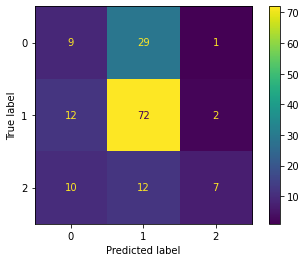

In [88]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disp=ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, cat_predict))
disp.plot()

In [89]:
feature_importance = pd.DataFrame(columns = ['feature_name', 'feature_importance'])
feature_importance['feature_name'] = X_train.keys()
feature_importance['feature_importance'] = estimator.feature_importances_ #svm_model.coef_.T #
feature_importance.sort_values(by='feature_importance', ascending=False)#[:50]

,feature_name,feature_importance
49,close_M_1_change,5.474
47,close_D_7_change,5.431
30,industry,4.221
48,close_D_14_change,4.186
52,close_M_6_change,3.724
51,close_M_3_change,3.612
50,close_M_2_change,3.160
23,P/E,2.880
53,close_Y_1_change,2.871
58,cos_month,2.814
